In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm

# Plot Style
plt.rcParams.update({'font.size': 15})

# Step 1: Download the data

In [47]:
df = pd.read_csv('data/strips_dec95.csv')
df.head()

,T,price
0,0.1260,99.393
1,0.6219,96.924
2,1.1260,94.511
3,1.6219,92.070
4,2.1260,89.644


In [48]:
df.shape

(117, 2)

# Step 2: Visualize the data

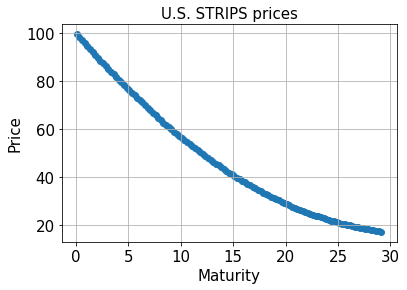

In [80]:
plt.scatter(df['T'],df['price'])
plt.ylabel('Price')
plt.xlabel('Maturity')
plt.title('U.S. STRIPS prices', fontsize = 15)
plt.grid()

In [81]:
def getEmpiricalFwrdRate(mat,price):
    n = len(mat)
    temp = np.zeros(n-1)
    for i in range(0,n-1):
        dt = mat[i+1]-mat[i]
        temp[i] = - np.log(price[i+1]/price[i])/dt  
    len(temp)
    return temp

In [82]:
rt = getEmpiricalFwrdRate(df['T'],df['price'])
mat = df['T'].iloc[1:]

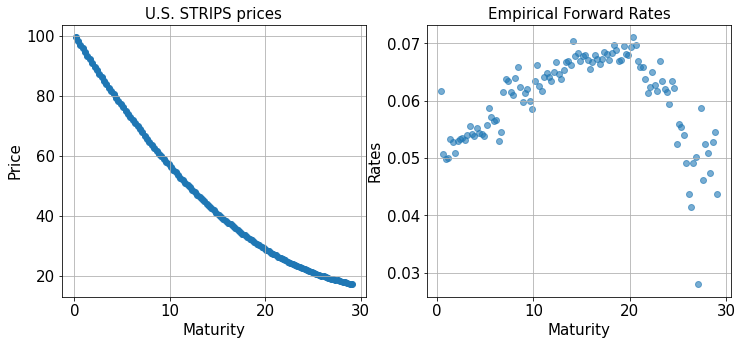

In [83]:
plt.figure(figsize=(12,5))
plt.subplot(1,2, 1)
plt.scatter(df['T'],df['price'])
plt.ylabel('Price')
plt.xlabel('Maturity')
plt.title('U.S. STRIPS prices', fontsize = 15)
plt.grid()
plt.subplot(1,2,2)
plt.scatter(mat,rt, alpha = 0.6)
plt.ylabel('Rates')
plt.xlabel('Maturity')
plt.title('Empirical Forward Rates', fontsize = 15)
plt.grid()
plt.savefig("US_STRIPS_PRICE_FWRDRATE")

# Step 3: Fit the curve

In [84]:
import scipy.optimize
from scipy.optimize import least_squares

In [85]:
#  Simple Quadratic in rt

def minFunc_quadratic(beta, T, yPrice):
    bondPrice = 100*np.exp(-beta[0]*T - beta[1] *T*T/2 - beta[2]*T*T*T/3)
    return (bondPrice - yPrice)

t_train = np.asarray(df['T'].values)
y_train = np.asarray(df['price'].values)            


In [86]:
#  Simple Cubic in rt

def minFunc_cubic(beta, T, yPrice):
    bondPrice = 100*np.exp(-beta[0]*T - beta[1] *T*T/2 - beta[2]*T*T*T/3- beta[3]*T*T*T*T/4)
    return (bondPrice - yPrice)

t_train = np.asarray(df['T'].values)
y_train = np.asarray(df['price'].values)            


In [87]:
res_quad = least_squares(minFunc_quadratic,x0_q, args = (t_train,y_train))
res_c = least_squares(minFunc_cubic,x0_c, args = (t_train,y_train))

In [88]:
res_quad.x

array([ 4.7492264e-02,  2.4032350e-03, -7.5424000e-05])

In [89]:
res_c.x

array([ 5.044677e-02,  9.005467e-04,  8.260526e-05, -4.327208e-06])

## In sample check

In [90]:
test_t = df['T'][20]
test_P = df['price'][20]

In [91]:
x0_q = np.array([0.047492264,0.002403235,-0.000075424])

minFunc_quadratic(x0_q, test_t , test_P )

-0.1447374241175723

In [92]:
x0_c = np.array([0.05044677,0.0009005467,0.00008260526,-0.000004327208])

minFunc_cubic(x0_c, test_t , test_P)

0.06903652066569066

# Step 4: Check the result

In [93]:
def genData_quadratic(mat, beta):
    n = len(mat)
    bondPrice = np.zeros(n)
    for i in range(n):
        T = mat[i]
        bondPrice[i] = 100*np.exp(-beta[0]*T - beta[1] *T*T/2 - beta[2]*T*T*T/3 )
    return bondPrice

In [94]:
def genData_cubic(mat, beta):
    n = len(mat)
    bondPrice = np.zeros(n)
    for i in range(n):
        T = mat[i]
        bondPrice[i] = 100*np.exp(-beta[0]*T - beta[1] *T*T/2 - beta[2]*T*T*T/3 - beta[3]*T*T*T*T/4 )
    return bondPrice

In [95]:
t_min = df['T'].min()
t_max = df['T'].max()
n_points = len(df)

t_test = np.linspace(t_min, t_max, n_points * 10)
y_true = y_train
y_lsq_q = genData_quadratic(t_test, res_quad.x)
y_lsq_c = genData_cubic(t_test, res_c.x)


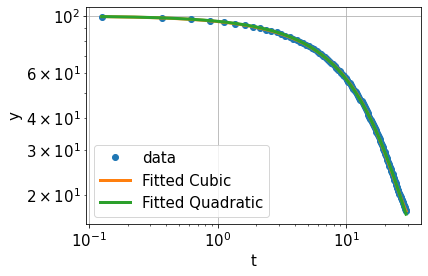

In [101]:
plt.plot(t_train, y_train, 'o',label='data')
plt.plot(t_test, y_lsq_c, linewidth=3,label='Fitted Cubic')
plt.plot(t_test, y_lsq_q, linewidth=3,label='Fitted Quadratic')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

In [102]:
rt_sq_q = getEmpiricalFwrdRate(t_test,y_lsq_q)
rt_sq_c = getEmpiricalFwrdRate(t_test,y_lsq_c)
m = len(rt_sq_q)
t_test_1 = np.zeros(m)
for i in range(m):
    t_test_1[i] = t_test[i+1] 

In [103]:
def get_quadratic(x,beta):
    n = len(x)
    r = np.zeros(n)
    for i in range(n):
        r[i] = beta[0]+beta[1]*x[i]+beta[2]*x[i]*x[i]
    return r

In [104]:
def get_cubic(x,beta):
    n = len(x)
    r = np.zeros(n)
    for i in range(n):
        r[i] = beta[0]+beta[1]*x[i]+beta[2]*x[i]*x[i] + beta[3]*x[i]*x[i]*x[i]
    return r

In [105]:
rt_sq_q = get_quadratic(t_test,res_quad.x)
rt_sq_c = get_cubic(t_test,res_c.x)

t_test_1 = t_test

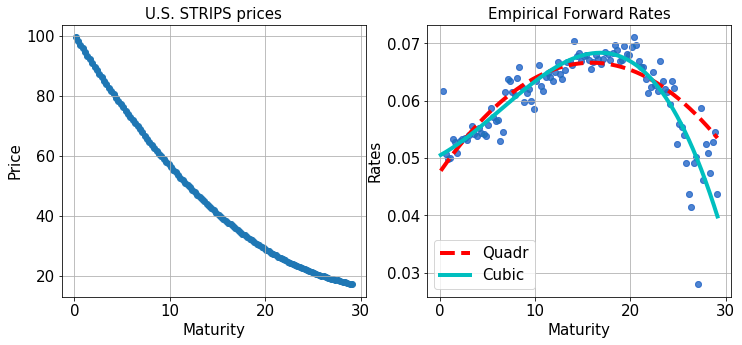

In [106]:
plt.figure(figsize=(12,5))
plt.subplot(1,2, 1)
plt.scatter(df['T'],df['price'])
plt.ylabel('Price')
plt.xlabel('Maturity')
plt.title('U.S. STRIPS prices', fontsize = 15)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(mat,rt, alpha = 0.4, color = 'b')
plt.plot(t_test_1,rt_sq_q, linewidth = 4, linestyle = 'dashed', color = 'r', label ='Quadr')
plt.scatter(mat,rt, alpha = 0.6)
plt.plot(t_test_1,rt_sq_c, linewidth = 4, color = 'c',label ='Cubic')
plt.ylabel('Rates')
plt.xlabel('Maturity')
plt.title('Empirical Forward Rates', fontsize = 15)
plt.grid()
plt.legend(loc='best');